In [3]:
import astropy
import numpy as np
import matplotlib
import scipy
import pandas as pd

from astropy.io import fits
from astropy.coordinates import SkyCoord 
from astropy.wcs import WCS
from astropy import units as u 

import matplotlib.pyplot as plt

from scipy.stats import sem 
from scipy.ndimage import gaussian_filter 

In [4]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'Black'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = (9, 6)

In [5]:
file = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_foreground_SMC.fits')
file.info()
file[0].header

Filename: /Users/FRANNYPACK/Downloads/grind!/research/Data/MW_foreground_SMC.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU   13495   (3901, 3471, 84)   float32   


SIMPLE  =                    T  /                                               
BITPIX  =                  -32  /                                               
NAXIS   =                    3  /                                               
NAXIS1  =                 3901  /                                               
NAXIS2  =                 3471  /                                               
NAXIS3  =                   84  /                                               
EXTEND  =                    T  /                                               
BSCALE  =    1.00000000000E+00  /                                               
BZERO   =    0.00000000000E+00  /                                               
BLANK   =                   -1  /                                               
BUNIT   = 'K       '  /                                                         
DATE-OBS= '2019-12-22T06:12:09.7'  /                                            
TELESCOP= 'ASKAP   '  /     

In [6]:
file[0].data[file[0].data == -32786] = np.nan

In [42]:
FUSE = pd.read_csv('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_H2_components.csv')
FUSE = FUSE[(FUSE["DEC"] < -69) & (FUSE["RA"] < 28)] # relevant stars in SMC

# H2

GUIDING QUESTION: at what separation distance does the structure function become randomized? 
(We expect upwards correlation and then randomized as distance from molecular cloud increases and then we leave the region altogether.)

This tells us the scale of the cold molecular structures (which tells us how/where the molecular hydrogen is forming in these diffuse regions); eg: if scale = 0.5 degrees, then sightline pairs with a smaller difference should be correlated. 

In [8]:
v_cen = FUSE['vcen'].to_numpy()

In [38]:
# helper function to compute difference between 2 column densities and square that 
# all values returned should be positive

def diff_and_square(cd1, cd2):
    return ((cd1 - cd2) ** 2)

In [37]:
# recursive helper function to get every permutation and the angular distances w/h them
# returns an array with every value of diff_and_square AND an array with the corresponding angular distances

def permute(arr, data):
    # base case
    if len(arr) == 0:
        return [], []
    
    cur = arr[0]
    # angular value of the current star being investigated
    cur_ang_val = SkyCoord(data.iloc[0]["RA"] * u.degree, data.iloc[0]["DEC"] * u.degree, frame = 'fk5')
    
    del arr[0]
    data = data.iloc[1:]
    
    count = 0 # records current index we are at in the array of col dens values
    final = [] # final = arr of diff_and_sq
    ang_dist = [] # ang_dist = arr of corresponding angular distances
    for i in arr:
        final.append(diff_and_square(cur, i))
        # angular value for the star being iterated through
        i_ang_val = SkyCoord(data.iloc[count]["RA"] * u.degree, data.iloc[count]["DEC"] * u.degree, frame = 'fk5')
        sep = cur_ang_val.separation(i_ang_val)
        ang_dist.append(sep.degree)
        count += 1
    
    recurse_f, recurse_ad = permute(arr, data)
    if len(recurse_f) != 0: 
        final += recurse_f
        ang_dist += recurse_ad
        
    return final, ang_dist

In [36]:
# helper function that returns an array of values to be averaged, given the number of values that should be in each bin
# bins by equal number of values in each bin

def sep_by_bin(values, ang_d, num_bin_vals, indx):
    arr = [] # = values for bin
    count = 0 # number of values in current bin
    order = np.argsort(np.array(ang_d))
    ang_d.sort() # sorting ang_d in increasing order
    values = np.array(values)[order].tolist() # sorting values in same order as ang_d so they correspond
    
    while (count < num_bin_vals) & (indx < len(values)):
        arr.append(values[indx])
        count += 1
        indx += 1
            
    return arr, indx


In [35]:
# helper function that does the work of binning by intaking an array of all values inside the < > 
# and the corresponding angular distances and the number of bins desired
# bins by equal number of values in each bin

def do_binning(diff_and_sq, ang_d, num_bins):
    num_bin_vals = len(diff_and_sq) / float(num_bins) # = number of values that should be in each bin
    indx = 0 # indx in diff_and_sq/ang_d that we at
    avgs = [] # holds mean values for each bin
    x_ax = [] # holds x-axis label values
    tot_err = [] # holds error bar values
    
    while (indx < len(diff_and_sq)):
        prev_indx = indx # for the x-axis label
        vals, indx = sep_by_bin(diff_and_sq, ang_d, num_bin_vals, indx)
        avgs.append(np.mean(vals))
        
        if indx < len(diff_and_sq):
            x_ax.append(str('%.1f' % (ang_d[prev_indx])) + '-' + str('%.1f' % (ang_d[indx])))
        else:
            x_ax.append(str('%.1f' % (ang_d[prev_indx])) + '-5')
            
        tot_err.append(sem(vals)) # error based on standard error of the mean
        
    return avgs, x_ax, tot_err, int(num_bin_vals)

In [34]:
# intakes a pandas file and number of bins and computes the mean for each, with an accompanying plot
# with error bars showing the standard error of the mean

def struct_func(num_bins, all_H2, xtick = 0):
    # obtaining values inside the average sign & angular distances
    N_H2 = FUSE['total_log10_N'].to_numpy()
    if all_H2 == True:
        FUSE2 = FUSE # copy of FUSE_data we can play with
    else:
        N_H2 = N_H2[(v_cen[:] >= -0.133) & (v_cen[:] <= 40)]
        FUSE2 = FUSE[(v_cen[:] >= -0.133) & (v_cen[:] <= 40)]
    diff_and_sq, ang_dist = permute(N_H2.tolist(), FUSE2)
    
    # binning
    avgs, x_ax, tot_err, num_bin_vals = do_binning(diff_and_sq, ang_dist, num_bins)
    
    # building plot
    fig, ax = plt.subplots()
    ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)
    
    if num_bins > 10: 
        ax.axes.get_xaxis().set_ticks([]) # don't include ticks/labels on x-axis since they become overcrowded
        
    ax.set_xlabel("Angular Distances (Degrees)")
    ax.set_ylabel("S(\u0394x) = $\mathregular{<[N(x_1) - N(x_2)]^2>}$ ($\mathregular{cm^{-2}}$)")
    if xtick != 0:
        ax.set_xticks([xtick])
    
    if all_H2:
        plt.title('(All)  $H_2$ - ' + str(num_bin_vals) + ' Values Per Bin, ' + str(num_bins) + ' Bins')
    else:
        plt.title('(Select)  $H_2$ - ' + str(num_bin_vals) + ' Values Per Bin, ' + str(num_bins) + ' Bins')
    

The below functions are for side-by-side plots

In [19]:
# helper function to get side-by-side plots (gets the arrays of values to plot)

def get_arr(num_bins, all_H2):
    
    # obtaining values inside the average sign & angular distances
    N_H2 = FUSE['total_log10_N'].to_numpy()
    if all_H2 == True:
        FUSE2 = FUSE # copy of FUSE_data we can play with
    else: # only include H2 in same velocity range as HI
        N_H2 = N_H2[(v_cen[:] >= -0.133) & (v_cen[:] <= 40)]
        FUSE2 = FUSE[(v_cen[:] >= -0.133) & (v_cen[:] <= 40)]
    diff_and_sq, ang_dist = permute(N_H2.tolist(), FUSE2)
    
    # binning
    avgs, x_ax, tot_err, num_bin_vals = do_binning(diff_and_sq, ang_dist, num_bins)
    return avgs, x_ax, tot_err, num_bin_vals

In [18]:
# plot the structure function plots (w/h all H2 and w/o) SIDE BY SIDE

def struct_func_H2_SS(num_bins, xtickL = 0, xtickR = 0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7), sharey = True)
    avgs1, x_ax1, tot_err1, num_bin_vals1 = get_arr(num_bins, True) # includes ALL H2
    ax1.errorbar(x_ax1, avgs1, yerr = tot_err1, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10) 
    ax1.set_title('All $H_2$ points')

    avgs2, x_ax2, tot_err2, num_bin_vals2 = get_arr(num_bins, False) # includes only H2 in HI velocity range
    ax2.errorbar(x_ax2, avgs2, yerr = tot_err2, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10) 
    ax2.set_title('Select $H_2$ points')

    if num_bins >= 10:
        ax1.axes.get_xaxis().set_ticks([]) # don't include ticks/labels on x-axis since they become overcrowded
        ax2.axes.get_xaxis().set_ticks([]) 
        
    if xtickL != 0:
        ax1.set_xticks([xtickL])
    if xtickR != 0:
        ax2.set_xticks([xtickR])
    


/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/2244491917.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.errorbar(x_ax1, avgs1, yerr = tot_err1, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)
/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/2244491917.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.errorbar(x_ax2, avgs2, yerr = tot_err2, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


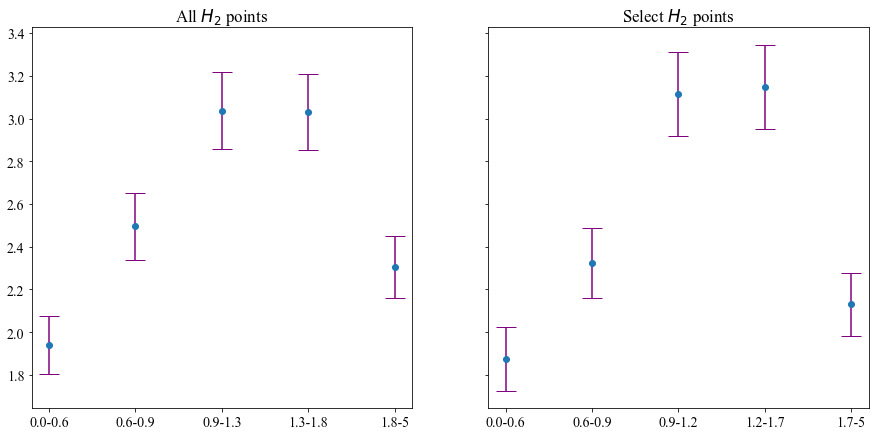

In [41]:
struct_func_H2_SS(5)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_82598/2898049443.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


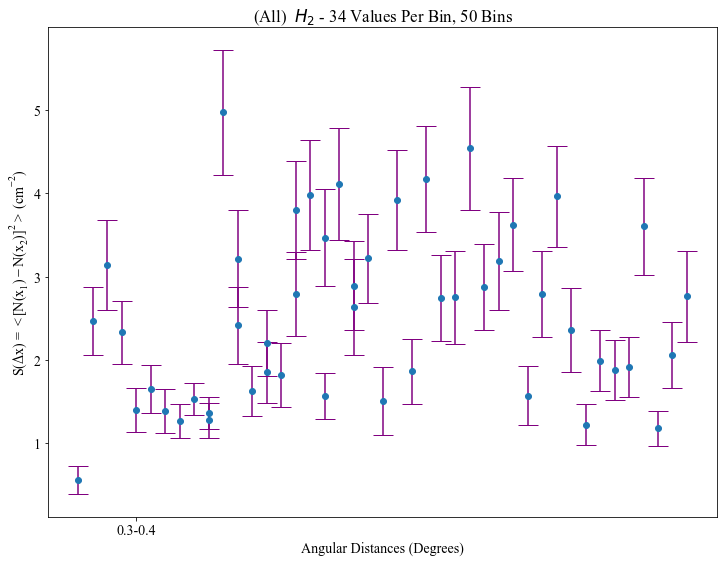

In [41]:
struct_func(50, True, xtick = 4)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/2244491917.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.errorbar(x_ax1, avgs1, yerr = tot_err1, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)
/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/2244491917.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.errorbar(x_ax2, avgs2, yerr = tot_err2, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


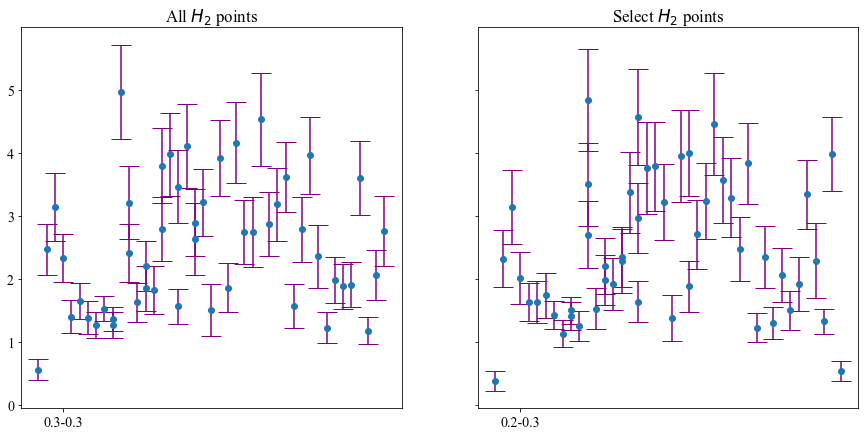

In [42]:
struct_func_H2_SS(50, 3, 3)

/Users/FRANNYPACK/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/FRANNYPACK/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/2898049443.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


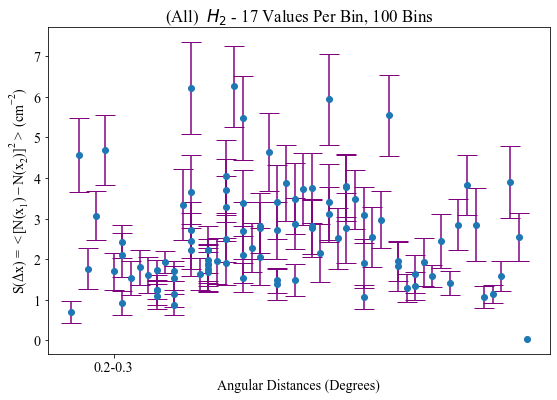

In [25]:
struct_func(100, True, xtick = 5)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/2898049443.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


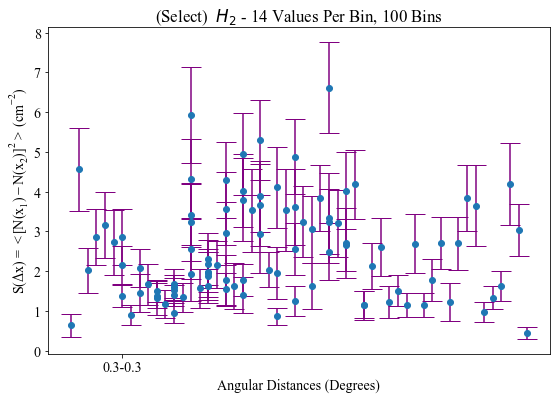

In [29]:
struct_func(100, False, xtick = 6)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/2587805210.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.errorbar(x_ax1, avgs1, yerr = tot_err1, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)
/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/2587805210.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.errorbar(x_ax2, avgs2, yerr = tot_err2, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


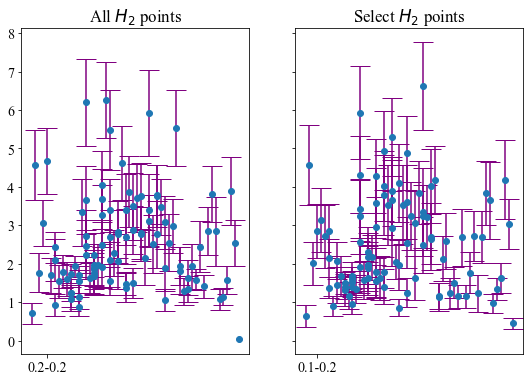

In [35]:
struct_func_H2_SS(100, 4, 3)

# HI

Below are functions to get the small-scale column density

In [50]:
# does the actual work of the USM

def process_usm(cc_sum, FWHM = 30.):
    
    pix_len = file[0].header['CDELT2'] * 60 # ['CDELT2'] = pixel length in deg, multiply by 60 to convert to arcmin
    FWHM30_pix = FWHM / pix_len # want FWHM to be 30 arcmin, so convert to pixels
    sigma = FWHM30_pix / (2 * np.sqrt(2 * np.log(2))) # converts from FWHM to sigma, since Gaussian filter specified by sigma
    sum_smooth = gaussian_filter(cc_sum, sigma = sigma) # does smoothing using Gaussian filter
    
    sum_USM = cc_sum - sum_smooth
    
    return sum_USM


In [51]:
# for multiple channel maps
# computes unsharp mask over 3 km/s at a time, then adds them up (so as to not wash out the small-scale structure)

def usm_cd(v_indx_min, v_indx_max, FWHM = 30., maskb = False):
    cur = v_indx_min
    num_iterations = int((v_indx_max - v_indx_min) / 3) # 3 km/s = 3 maps at a time
    tot_cd = np.zeros((3471, 3901))
    
    for i in range(num_iterations + 1):
        if (i == num_iterations): # remainder of 3 that we have to integrate over
            if ((v_indx_max - v_indx_min) % 3 == 0): # nothing left to integrate over - we done!
                tot_cd[np.where(tot_cd < 0.)] = 0. 
                return tot_cd
            else:
                cd_arr = 1.82 * (10 ** 18) * np.nansum(file[0].data[cur:v_indx_max], axis = 0) * 0.977198303456
        else: 
            cd_arr = 1.82 * (10 ** 18) * np.nansum(file[0].data[cur:cur + 3], axis = 0) * 0.977198303456
        
        if maskb:
            cd_arr = mask_border(cd_arr)
            
        tot_cd += process_usm(cd_arr, FWHM = FWHM)
        cur += 3
        
    tot_cd[np.where(tot_cd < 0.)] = 0. # do at end so negative noise cancels out with positive noise
    return tot_cd

In [55]:
# gives arr of H1 col densities given the pixels with which the background stars corresponded to 

def col_dens_arr(pix_arr, col_dens_vals, log = True):
    HI_col_dens = []
    HI_col_dens_nolog = [] # array of the col dens w/o a logarithmic function applied to it
    for i in range(0, len(pix_arr)):
        # RA values = 0, Dec = 1 BUT the rows in col_dens_vals = y-values, cols = x-values
        col_dens = col_dens_vals[int(pix_arr[i][1])][int(pix_arr[i][0])] 
        # so the values are logarithmic (to match H2 col dens) and in cm^-2
        HI_col_dens_nolog.append(col_dens)
        HI_col_dens.append(np.log10(col_dens))
    
    if log:
        return HI_col_dens
    else:
        return HI_col_dens_nolog

In [53]:
tot_col_dens_SS = usm_cd(0, 83)

Below are functions to get the HI structure functions

In [46]:
# make 2D header 
def make_flat_hdr(file):
    hdr = file[0].header
    
    # Make a 2D header 
    flathdr = fits.Header()
    flathdr["NAXIS   "] = 2
    flathdr["NAXIS1  "] = hdr["NAXIS1  "]
    flathdr["NAXIS2  "] = hdr["NAXIS2  "]
    flathdr["CRPIX1  "] = hdr["CRPIX1  "]
    flathdr["CRPIX2  "] = hdr["CRPIX2  "]
    flathdr["CRVAL1  "] = hdr["CRVAL1  "]
    flathdr["CRVAL2  "] = hdr["CRVAL2  "]
    flathdr["CDELT1  "] = hdr["CDELT1  "]
    flathdr["CDELT2  "] = hdr["CDELT2  "]
    flathdr["CTYPE1  "] = hdr["CTYPE1  "]
    flathdr["CTYPE2  "] = hdr["CTYPE2  "]
    flathdr["LONPOLE "] = hdr["LONPOLE "]
    flathdr["LATPOLE "] = hdr["LATPOLE "]
    
    return flathdr

In [47]:
file_flat_hdr = make_flat_hdr(file)

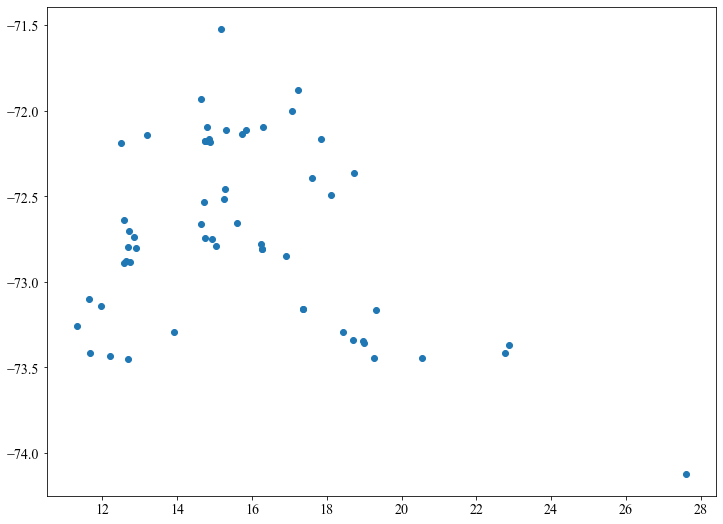

In [48]:
scatter_pts = plt.scatter(FUSE['RA'], FUSE['DEC'], cmap = 'Reds')
ra_vals = scatter_pts.get_offsets()[:,0] # gets RA vals
dec_vals = scatter_pts.get_offsets()[:,1] # gets dec vals

pix_arr = get_pix_vals(file_flat_hdr, ra_vals, dec_vals)

In [63]:
# gives pix vals associated w RA/DEC vals using FITS header

def get_pix_vals(flat_FITS_hdr, ra_values, dec_values):
    wcs = WCS(flat_FITS_hdr)
    pix_arr = []
    x_pix = []
    y_pix = []
    for i in range(0, len(ra_values)):
        arr = []
        x_pix, y_pix = wcs.all_world2pix(ra_values[i], dec_values[i], 0)
        arr.append(x_pix)
        arr.append(y_pix)
        pix_arr.append(arr)
    
    return pix_arr

In [62]:
# recursive helper function to get every permutation and the angular distances w/h them for HI
# "arr" = HI column density values
# "RA" and "DEC" = corresponding values to the HI column density values
# returns an array with every value of diff_and_square AND an array with the corresponding angular distances

def permute_HI(arr, RA, DEC):
    # base case
    if len(arr) == 0:
        return [], []
    
    cur = arr[0]
    # angular value of the current star being investigated
    cur_ang_val = SkyCoord(RA[0] * u.degree, DEC[0] * u.degree, frame = 'fk5')
    
    del arr[0]
    RA = np.delete(RA, 0)
    DEC = np.delete(DEC, 0)
    
    count = 0 # records current index we are at in the array of col dens values
    final = [] # final = arr of diff_and_sq
    ang_dist = [] # ang_dist = arr of corresponding angular distances
    for i in arr:
        final.append(diff_and_square(cur, i))
        # angular value for the star being iterated through
        i_ang_val = SkyCoord(RA[count] * u.degree, DEC[count] * u.degree, frame = 'fk5')
        sep = cur_ang_val.separation(i_ang_val)
        ang_dist.append(sep.degree)
        count += 1
    
    recurse_f, recurse_ad = permute_HI(arr, RA, DEC)
    if len(recurse_f) != 0: 
        final += recurse_f
        ang_dist += recurse_ad
        
    return final, ang_dist

In [61]:
# gets pix_arr & col_dens_arr for 58 random lines of sight (since there's 58 lines of sight for N_H2) for HI

def get_random_pix():
    RA, DEC = np.zeros(57), np.zeros(57)
    for i in range(len(RA)): # gets random values for RA & DEC
        RA[i] = np.random.uniform(4.5, 25) 
        DEC[i] = np.random.uniform(-75, -70)
        
    pix_arr = get_pix_vals(file_flat_hdr, RA, DEC)
    return pix_arr

In [60]:
# intakes a pandas file and number of bins and computes the mean for each, with an accompanying plot
# with error bars showing the standard error of the mean

def struct_func_HI(num_bins, cd, title, random_sight = False, xtick = 0):
    
    # obtaining values inside the average sign & angular distances
    if random_sight == True: # use random HI pixel values (but still same number of sightlines as N_H2)
        rand_pix = get_random_pix()
        N_HI = col_dens_arr(rand_pix, cd)
    else: # use the exact same sightlines as N_H2
        N_HI = col_dens_arr(pix_arr, cd)
        
    diff_and_sq, ang_dist = permute_HI(N_HI, ra_vals, dec_vals)
    count = 0
    while count < len(diff_and_sq):
        if (np.isnan(diff_and_sq[count])) | (np.isposinf(diff_and_sq[count])):
            diff_and_sq.pop(count)
            ang_dist.pop(count)
            count -= 1
        count += 1
    
    # binning
    avgs, x_ax, tot_err, num_bin_vals = do_binning(diff_and_sq, ang_dist, num_bins)
    
    # building plot
    fig, ax = plt.subplots()
    ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)
    
    if num_bins > 10: 
        ax.axes.get_xaxis().set_ticks([]) # don't include ticks/labels on x-axis since they become overcrowded
    
    if xtick != 0:
        ax.set_xticks([xtick])
    ax.set_xlabel("Angular Distances (Degrees)")
    ax.set_ylabel("S(\u0394x) = $\mathregular{<[N(x_1) - N(x_2)]^2>}$ ($\mathregular{cm^{-2}}$)")
    plt.title('HI - ' + title + ', ' + str(num_bins) + ' Bins, ' + str(num_bin_vals) + ' Values Per Bin', fontsize = 25)
    

Using exact same sightlines as H2

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/536117764.py:11: RuntimeWarning: divide by zero encountered in log10
  HI_col_dens.append(np.log10(col_dens))
/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/2828851890.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return ((cd1 - cd2) ** 2)
/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/4133498405.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


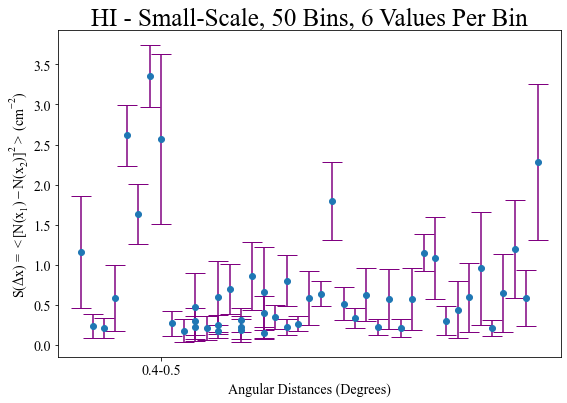

In [72]:
struct_func_HI(50, tot_col_dens_SS, title = 'Small-Scale', xtick = 7)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/536117764.py:11: RuntimeWarning: divide by zero encountered in log10
  HI_col_dens.append(np.log10(col_dens))
/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/2828851890.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return ((cd1 - cd2) ** 2)
/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/4133498405.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


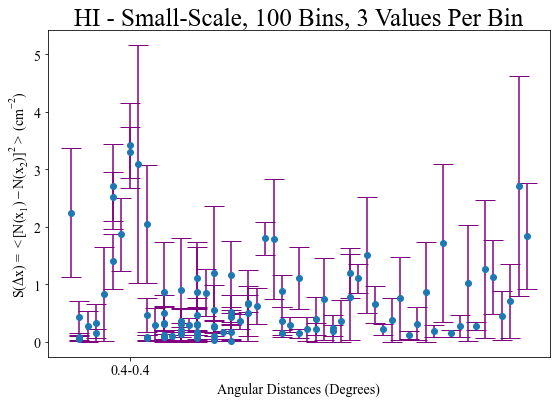

In [78]:
struct_func_HI(100, tot_col_dens_SS, title = 'Small-Scale', xtick = 7)

In [79]:
tot_col_dens = 1.82 * (10 ** 18) * np.nansum(file[0].data, axis = 0) * 0.977198303456 # in cm^-2

In [80]:
tot_col_dens_LS = tot_col_dens - tot_col_dens_SS

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/4133498405.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


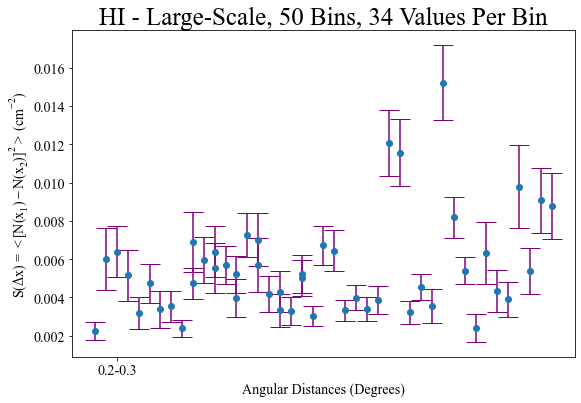

In [88]:
struct_func_HI(50, tot_col_dens_LS, title = 'Large-Scale', xtick = 2)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_4020/4133498405.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(x_ax, avgs, yerr = tot_err, fmt = '-o', ls = 'none', ecolor = 'purple', capsize = 10)


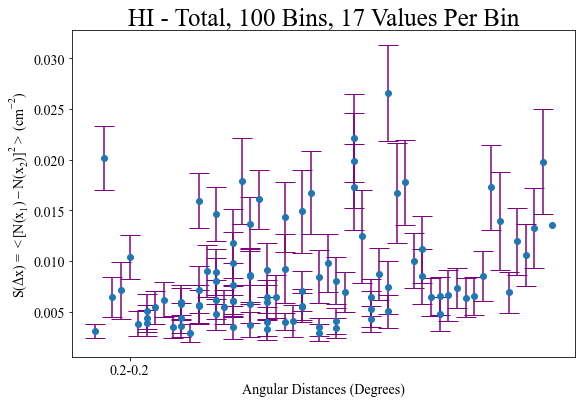

In [94]:
struct_func_HI(100, tot_col_dens, title = 'Total', xtick = 4)